# Retrieval Augmented Prediction Model

This Model, specifically created to make Stock Predictions for upcoming Businesses, means this model predicts the market startup of any new business idea.


In [4]:
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from RetrievalSystem.RetrievalSystem import RetrievalSystem
from PredictionModel.AttentionModel.AttentionModel import AttentionModel
import pandas as pd
import numpy as np
from PredictionModel.Layers.Layers import SimilarityLayer, IdeaLayer, IdeaStaticLayer, IdeaHistoricalLayer, StaticFeatureLayer, HistoricalFeatureLayer, FirstFusionLayer, SecondFusionLayer, OutputLayer

INPUT_PATH = "../RetrievalSystem/Embeddings/embeddings.csv"

BERT_DIM = 384

class RetrievalAugmentedPredictionModel(nn.Module):
    def __init__(self, hidden_dim: int = 128, ret_sys: RetrievalSystem = None, static_dim = 34, historical_dim = 72, forecast_steps: int = 6, retrieval_number: int = 16):
        super(RetrievalAugmentedPredictionModel, self).__init__()

        self.forecast_steps = forecast_steps
        self.static_feature_dim = static_dim
        self.historical_feature_dim = historical_dim
        self.historical_idea_dim = historical_dim - forecast_steps
        self.retrieval_number = retrieval_number

        # Retrieval Model
        if ret_sys:
            self.retrieval_system = ret_sys
        else:
            self.retrieval_system = RetrievalSystem(INPUT_PATH, retrieval_number)

        # Layers for retrieved documents
        self.attention_model = AttentionModel(input_dim=BERT_DIM, hidden_dim=hidden_dim)
        self.similarity_fc = SimilarityLayer(retrieval_number=retrieval_number)
        self.static_fc = StaticFeatureLayer(retrieval_number=retrieval_number,hidden_dim=hidden_dim, static_feature_dim=self.static_feature_dim)
        self.historical_fc = HistoricalFeatureLayer(retrieval_number=retrieval_number, hidden_dim=hidden_dim, historical_feature_dim=self.historical_feature_dim)

        # Layers for new Idea
        self.idea_fc = IdeaLayer(bert_dim=BERT_DIM, hidden_dim=hidden_dim)
        self.idea_static_fc = IdeaStaticLayer(static_feature_dim=self.static_feature_dim)
        self.idea_historical_fc = IdeaHistoricalLayer(historical_idea_dim=self.historical_idea_dim, hidden_dim=hidden_dim)

        # 1.Fusion Layer
        self.first_fusion_fc = FirstFusionLayer(bert_dim=BERT_DIM, hidden_dim=hidden_dim, retrieval_number=retrieval_number)
        self.fusion_attention = nn.MultiheadAttention(embed_dim=3 * hidden_dim, num_heads=4, batch_first=True)

        # 2.Fusion Layer
        self.second_fusion_fc = SecondFusionLayer(hidden_dim=hidden_dim)
        self.second_fusion_attention = nn.MultiheadAttention(embed_dim=2 * hidden_dim, num_heads=2, batch_first=True)

        # Multi-layer LSTM with residual connection
        self.lstm = nn.LSTM(2 * hidden_dim, 1 * hidden_dim, num_layers=3, batch_first=True, dropout=0.2)

        # Attention mechanism
        self.attention = nn.MultiheadAttention(embed_dim=1 * hidden_dim, num_heads=2, batch_first=True)

        # Output layer for forecasting
        self.output_fc = OutputLayer(hidden_dim=hidden_dim)


    def forward(self, ideas: list, dataset: pd.DataFrame = None, static_features=None, historical_data=None, use_auxiliary_inputs=True, excluded_tickers: dict = None):
        # Ensure device compatibility
        if excluded_tickers is None:
            excluded_tickers = {}
        if dataset is None:
            print("We need a dataset for retrieval")
            return None

        device = next(self.parameters()).device

        # --- Retrieval Model ---
        # Batch retrieve embeddings and documents
        retrieval_results = self.retrieval_system.find_similar_entries_for_batch(texts=ideas, top_n=self.retrieval_number, excluded_tickers=excluded_tickers)

        # Extract embeddings, similarities, and tickers for the batch
        idea_embeddings, retrieved_embeddings, retrieved_similarities, retrieved_tickers = [], [], [], []
        for embedding, documents in retrieval_results:
            idea_embeddings.append(embedding)
            retrieved_embeddings.append(torch.tensor(documents['embedding'].tolist(), dtype=torch.float32).to(device))
            retrieved_similarities.append(torch.tensor(documents['similarity'].tolist(), dtype=torch.float32).to(device))
            retrieved_tickers.append(documents['tickers'].values)

        # Convert to tensors for further processing
        idea_embeddings = np.array(idea_embeddings, dtype=np.float32)  # Convert to NumPy array
        idea_embeddings = torch.tensor(idea_embeddings, dtype=torch.float32).to(device).squeeze(1)

        retrieved_idea_embeddings = torch.stack(retrieved_embeddings).to(device)  # [batch_size, num_retrieved, embedding_dim]
        retrieved_similarities = torch.stack(retrieved_similarities).to(device)  # [batch_size, num_retrieved]

        # --- Preparing Inputs for Layer ---

        print("Retrieved tickers: ", retrieved_tickers)
        dataset = dataset.set_index("tickers")

        # Filter rows from the dataset and extract numeric data
        filtered_data = []
        for i in range(len(retrieved_tickers)):
            tickers = retrieved_tickers[i]
            filtered = dataset[dataset.index.isin(tickers)]

            # Select numeric columns only
            numeric_data = filtered.select_dtypes(include=['number']).apply(pd.to_numeric, errors='coerce').fillna(0).values
            filtered_data.append(numeric_data)

        # Convert filtered data into a batch tensor with padding
        filtered_data = [torch.tensor(row, dtype=torch.float32) for row in filtered_data]
        filtered_data = pad_sequence(filtered_data, batch_first=True).to(device)  # [batch_size, padded_length, numeric_dim]
        print("We have these retrieved documents: ", filtered_data.shape)

        # Define static and month columns
        static_columns = [
            col for col in dataset.columns
            if col not in ["tickers", "business_description"] and not col.startswith("month")
        ]
        month_columns = [col for col in dataset.columns if col.startswith("month")]

        # Extract static and month vectors for each batch
        static_vectors = []
        month_vectors = []

        for i in range(len(retrieved_tickers)):
            tickers = retrieved_tickers[i]
            filtered = dataset[dataset.index.isin(tickers)]

            # Extract static data
            static_data = filtered[static_columns].apply(pd.to_numeric, errors='coerce').fillna(0).values
            static_vectors.append(static_data.flatten())  # Flatten to handle batch processing

            # Extract month data
            month_data = filtered[month_columns].apply(pd.to_numeric, errors='coerce').fillna(0).values
            month_vectors.append(month_data.flatten())  # Flatten to handle batch processing

            print(f"Shapes: month_data: {month_data.shape}, static_data: {static_data.shape}")

        # Convert to tensors
        combined_static_tensor = np.array(static_vectors, dtype=np.float32)  # Convert to NumPy array
        combined_static_tensor = torch.tensor(combined_static_tensor, dtype=torch.float32).to(device)  # [batch_size, static_dim]
        combined_historical_tensor = np.array(month_vectors, dtype=np.float32)  # Convert to NumPy array
        combined_historical_tensor = torch.tensor(combined_historical_tensor, dtype=torch.float32).to(device)  # [batch_size, historical_dim]

        print(f"Static Tensor Shape: {combined_static_tensor.shape}, Historical Tensor Shape: {combined_historical_tensor.shape}")

        # --- AttentionModel, IdeaInput, 1.FusionLayer ---
        # Put retrieved documents into appropriate input layers
        weighted_sum, attention_weights = self.attention_model(retrieved_idea_embeddings)
        attention_weights = attention_weights.view(attention_weights.size(0), -1, 1)  # Retain batch size
        print(f"Shape of weighted_sum: {weighted_sum.shape}, attention_weights: {attention_weights.shape}")

        similarity_output = self.similarity_fc(retrieved_similarities)  # [batch_size, feature_dim]
        combined_static_output = self.static_fc(combined_static_tensor)  # [batch_size, feature_dim]
        combined_historical_output = self.historical_fc(combined_historical_tensor)  # [batch_size, feature_dim]

        print(f"Shape of static_output: {combined_static_output.shape}, similarity: {similarity_output.shape}, historical: {combined_historical_output.shape}")

        # Ensure attention_weights matches the batch size
        attention_weights = attention_weights.squeeze(-1)  # Remove the last dimension if not needed
        print(f"Shapes: weighted_sum: {weighted_sum.shape}, attention_weights: {attention_weights.shape}, combined_static_output: {combined_static_output.shape}, combined_historical: {combined_historical_output.shape}, similarity: {similarity_output.shape}")

        # Concatenate along the last dimension
        combined_retrieval_input = torch.cat((
            weighted_sum, attention_weights, combined_static_output, combined_historical_output, similarity_output
        ), dim=-1)  # Concatenation along the last dimension
        print(f"Shape of combined_retrieval_input: {combined_retrieval_input.shape}")

        first_fusion_output = self.first_fusion_fc(combined_retrieval_input)

        # Attention layer
        first_fusion_attention_output, _ = self.fusion_attention(first_fusion_output, first_fusion_output, first_fusion_output)

        # Put new ideas data into input layers
        idea_output = self.idea_fc(idea_embeddings)

        batch_size = idea_embeddings.size(0)
        if use_auxiliary_inputs:
            static_tensor = static_features.clone().to(torch.float32).to(device)
            historical_tensor = historical_data.clone().to(device)
        else:
            static_tensor = torch.zeros((batch_size, self.static_feature_dim), dtype=torch.float32).to(device)
            historical_tensor = torch.zeros((batch_size, self.historical_idea_dim), dtype=torch.float32).to(device)

        static_output = self.idea_static_fc(static_tensor) # This wont change within the autoregressiv prediction

        # --- Autoregressive prediction ---
        predictions = []
        for step in range(self.forecast_steps):
            historical_output = self.idea_historical_fc(historical_tensor)

            # 2. FUSION LAYER - Fuse combined retrieval documents and new idea together
            print(f"Shapes of static_output: {static_output.shape}, historical_output: {historical_output.shape}, idea: {idea_output.shape}, attention_output: {first_fusion_attention_output.shape}")

            combined_idea_input = torch.cat((first_fusion_attention_output, idea_output, static_output, historical_output), dim=1)
            second_fusion_output = self.second_fusion_fc(combined_idea_input)

            # Attention layer
            second_fusion_attention_output, _ = self.second_fusion_attention(second_fusion_output, second_fusion_output, second_fusion_output)

            # LSTM
            lstm_output, _ = self.lstm(second_fusion_attention_output.unsqueeze(1))  # Add sequence dimension

            # Attention
            lstm_attention_output, _ = self.attention(lstm_output, lstm_output, lstm_output)

            # OUTPUT
            final_prediction = self.output_fc(lstm_attention_output.squeeze(1))  # Remove sequence dimension

            # Append to predictions
            predictions.append(final_prediction)

            # Update historical tensor for next step
            historical_tensor = torch.cat((historical_tensor[:, 1:], final_prediction), dim=1)

        # Stack predictions into a single tensor
        predictions = torch.cat(predictions, dim=1)  # Shape: [1, forecast_steps, 1]
        predictions = predictions.to(torch.float32).to(device)  # Retain computational graph
        return predictions



### Example usage
Here is an example of how to use our newly created model:

In [5]:
import torch
# Initialize the model - HAVE TO BE ADAPTED TO DATASET (Values are likely correct)
static_feature_dim_num = 4    # Number of static features
historical_dim_num = 12       # Number of historical stock performance points
hidden_dim_num = 128          # Hidden layer size
forecast_steps_num = 6       # Predict next 12 months

batch_size = 9

DATASET_PATH = "../Dataset/Data/normalized_real_company_stock_dataset_large.csv"
dataset = pd.read_csv(DATASET_PATH)
print(f"Datasetshape: {dataset.shape}")

print(f"Datasetshape: {dataset.shape}")

retrieval_system = RetrievalSystem(INPUT_PATH, retrieval_number=5)

model = RetrievalAugmentedPredictionModel(
    forecast_steps=forecast_steps_num,
    ret_sys = retrieval_system,
    retrieval_number=5
)

current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Random entry
idea_entries = dataset.iloc[10:10 + batch_size, :]  # Get a batch of rows

# Removed tickers: Select rows from index 3 onward
removed_tickers = [] # dataset.iloc[100:, :]["tickers"].tolist()

# Create excluded_tickers map
excluded_tickers = {
    i: [ticker] + removed_tickers  # Include the ticker itself and all removed tickers
    for i, ticker in enumerate(dataset["tickers"])
}

ideas = idea_entries["business_description"].tolist()

static_columns = [
    col for col in dataset.columns
    if col not in ["tickers", "business_description"] and not col.startswith("month")
]
month_columns = [col for col in dataset.columns if col.startswith("month")]

# Prepare static and historical data for the batch
static_data = idea_entries[static_columns]
historical_data = idea_entries[month_columns]

# Ensure numeric data and handle missing values
static_data = static_data.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(float)
historical_data = historical_data.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(float)

# Convert to tensors with batch dimension
static_data = torch.tensor(static_data, dtype=torch.float32).to(current_device)  # [batch_size, static_feature_dim_num]
historical_data = torch.tensor(historical_data[:, -len(month_columns):-forecast_steps_num], dtype=torch.float32).to(current_device)  # [batch_size, historical_dim_num]

# Make a prediction
prediction = model(
    ideas=ideas,
    dataset=dataset,
    static_features=static_data,
    historical_data=historical_data,
    use_auxiliary_inputs=True,
    excluded_tickers=excluded_tickers,
)
print(prediction)  # Co
print(prediction.shape)


# Make a prediction
prediction = model(
    ideas=ideas,
    dataset=dataset,
    use_auxiliary_inputs=False
)
print(prediction)  # Co
print(prediction.shape)



Datasetshape: (7089, 108)
Datasetshape: (7089, 108)
Retrieved tickers:  [array(['AAPL', 'BBY', 'JAMF', 'NKE', 'ZEPP'], dtype=object), array(['AAT', 'SVC', 'SILA', 'CMCT', 'DHC'], dtype=object), array(['AB', 'LPLA', 'WBIG', 'WBIL', 'WBIF'], dtype=object), array(['ABAT', 'LICY', 'AMLI', 'ELBM', 'NVX'], dtype=object), array(['ABBV', 'REGN', 'ALVO', 'CPIX', 'TNXP'], dtype=object), array(['ABCB', 'ASRV', 'FFBC', 'TBBK', 'IROQ'], dtype=object), array(['ABCL', 'ABP', 'ROIV', 'CLDX', 'SMMT'], dtype=object), array(['ABEO', 'ABP', 'ABVC', 'OTLK', 'UBX'], dtype=object), array(['ABEV', 'BUD', 'CCU', 'TAP', 'CCEP'], dtype=object)]
We have these retrieved documents:  torch.Size([9, 5, 106])
Shapes: month_data: (5, 72), static_data: (5, 34)
Shapes: month_data: (5, 72), static_data: (5, 34)
Shapes: month_data: (5, 72), static_data: (5, 34)
Shapes: month_data: (5, 72), static_data: (5, 34)
Shapes: month_data: (5, 72), static_data: (5, 34)
Shapes: month_data: (5, 72), static_data: (5, 34)
Shapes: month_

### Simple Training Loop

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


# Define a PyTorch Dataset
class StockDataset(Dataset):
    def __init__(self, dataset, forecast_steps, static_columns, month_columns):
        self.dataset = dataset
        self.forecast_steps = forecast_steps
        self.static_columns = static_columns
        self.month_columns = month_columns

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        idea_entry = self.dataset.iloc[idx]

        # Extract idea, static data, historical data, and target
        idea = idea_entry["business_description"]
        ticker = idea_entry["tickers"]

        static_data = idea_entry[self.static_columns]
        historical_data = idea_entry[self.month_columns]

        # Handle missing values
        static_data = static_data.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(float)
        historical_data = historical_data.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(float)

        # Split target and input
        target = torch.tensor(historical_data[-self.forecast_steps:], dtype=torch.float32)
        historical_data = torch.tensor(historical_data[:-self.forecast_steps], dtype=torch.float32)

        # Return all relevant data
        return idea, static_data, historical_data, target, ticker


# Initialize dataset and DataLoader
static_columns = [
    col for col in dataset.columns
    if col not in ["tickers", "business_description"] and not col.startswith("month")
]
month_columns = [col for col in dataset.columns if col.startswith("month")]

forecast_steps = 6
batch_size = 10
retrieval_number = 10

stock_dataset = StockDataset(dataset, forecast_steps, static_columns, month_columns)
data_loader = DataLoader(stock_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
retrieval_system = RetrievalSystem(INPUT_PATH, retrieval_number=10)
model = RetrievalAugmentedPredictionModel(
    forecast_steps=forecast_steps,
    ret_sys=retrieval_system,
    retrieval_number=10,
)
model.to(current_device)

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Initialize storage for loss values
losses = []

# Training loop
epochs = 1
for epoch in range(epochs):
    total_loss = 0.0

    for batch in data_loader:
        ideas, static_data, historical_data, targets, tickers = batch

        static_data = static_data.clone().detach().to(current_device)
        historical_data = torch.stack([h.clone().detach() for h in historical_data]).to(current_device)
        targets = torch.stack([t.clone().detach() for t in targets]).to(current_device)

        # Remove tickers in the current batch from the dataset for retrieval
        excluded_tickers = list(tickers)

        # Forward pass
        predictions = model(
            ideas=ideas,
            dataset=dataset,
            static_features=static_data,
            historical_data=historical_data,
            use_auxiliary_inputs=True,
            excluded_tickers={i: [ticker] + removed_tickers for i, ticker in enumerate(excluded_tickers)}
        )

        # Compute loss
        loss = loss_fn(predictions, targets)
        total_loss += loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Store epoch loss
    losses.append(total_loss)

    # Print epoch summary
    print(f"Epoch [{epoch + 1}/{epochs}] completed. Total Loss: {total_loss:.4f}")



Retrieved tickers:  [array(['VDE', 'VPU', 'VFH', 'VIS', 'VAW', 'VGT', 'VCR', 'VHT', 'VDC',
       'MGK'], dtype=object), array(['CMTL', 'GILT', 'SATS', 'VSAT', 'TSAT', 'IRDM', 'COMM', 'VIAV',
       'TDS', 'SATX'], dtype=object), array(['BLKB', 'BL', 'NNI', 'ASB', 'BXSL', 'CLBT', 'TCPC', 'ACNB', 'TBRG',
       'DSS'], dtype=object), array(['MAMO', 'FLYE', 'MPX', 'PII', 'RMBL', 'FOXF', 'TWIN', 'CLAR',
       'HZO', 'FUV'], dtype=object), array(['ETHO', 'REMX', 'SPXE', 'CRBN', 'IYK', 'SPXT', 'JHMM', 'JPIN',
       'PBW', 'IYE'], dtype=object), array(['SLNHP', 'SLNH', 'BTCM', 'RIOT', 'CIFR', 'HUT', 'CLSK', 'CORZ',
       'DGHI', 'HIVE'], dtype=object), array(['VRA', 'BKE', 'TPR', 'UA', 'UAA', 'DECK', 'XELB', 'DBGI', 'LVLU',
       'FIVE'], dtype=object), array(['HDV', 'ISCB', 'IMCB', 'ILCB', 'IYLD', 'INDA', 'IGM', 'IXG',
       'SPBO', 'RXI'], dtype=object), array(['BABA', 'JXJT', 'OLB', 'AGBA', 'GB', 'WB', 'TAOP', 'ICLK', 'QH',
       'TC'], dtype=object), array(['BCG', 'JHG', 'MATH', 'T

KeyboardInterrupt: 

# Evaluation

Retrieved tickers:  [array(['JVA', 'KDP', 'WEST', 'THCH', 'FARM', 'SBUX', 'REBN', 'DCI',
       'CLWT', 'FIZZ'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_

/tmp/ipykernel_58582/1260532541.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()  # Add legend to differentiate between predictions and targets


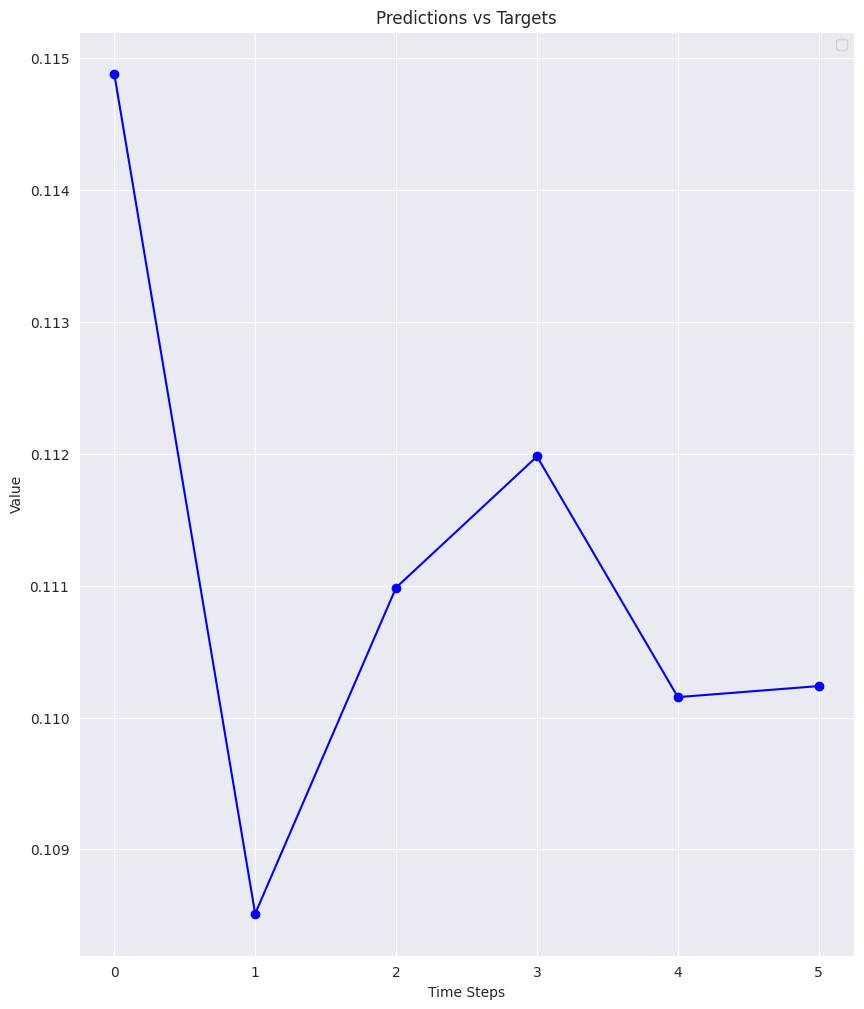

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

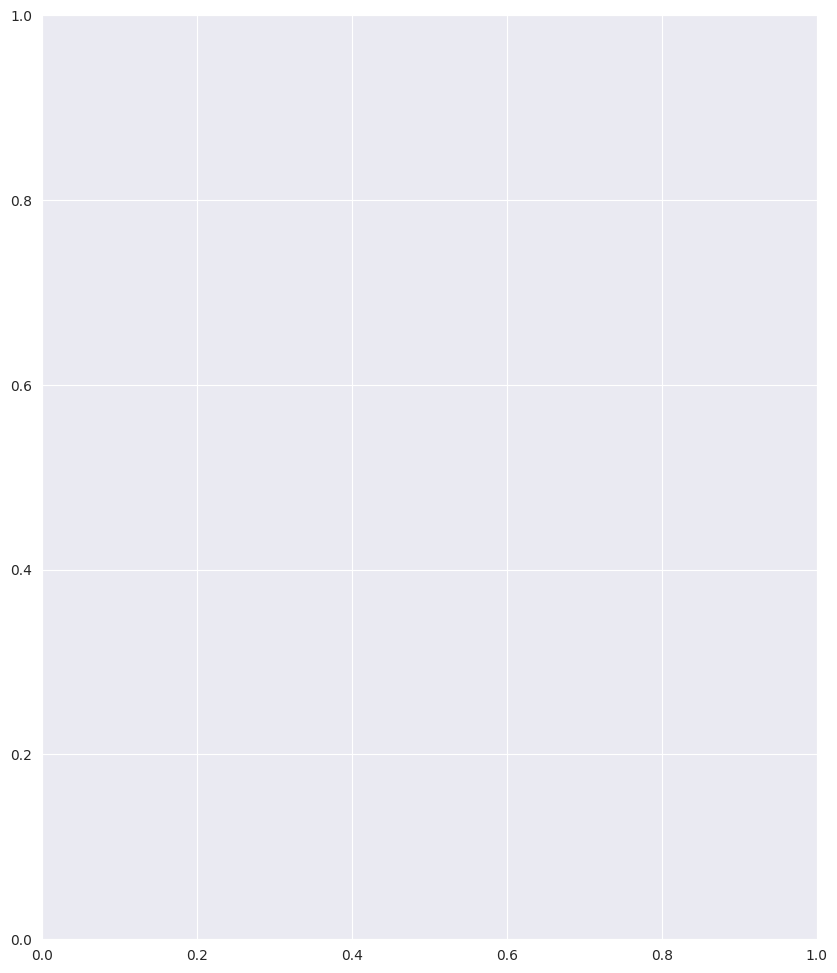

In [18]:

# Example post-training prediction
example_idea = "I want to create a coffee shop that uses digital cups to analyze what's in your coffee and its impact on you."
prediction = model(
    ideas=[example_idea],
    dataset=dataset,
    use_auxiliary_inputs=False
)
print("Prediction after training:", prediction)

# Flatten the lists to make evaluation easier
all_predictions = np.concatenate(prediction.detach().numpy(), axis=0)

plt.figure(figsize=(10, 12))
plt.plot(all_predictions, linestyle='-', marker='o', color='blue')
plt.xlabel('Time Steps')  # Or whatever your x-axis represents
plt.ylabel('Value')  # Or whatever your y-axis represents
plt.title('Predictions vs Targets')
plt.legend()  # Add legend to differentiate between predictions and targets
plt.grid(True)
plt.show()

# Example post-training prediction
example_idea = "I want to create a coffee shop that uses digital cups to analyze what's in your coffee and its impact on you."
prediction = model(
    ideas=[example_idea],
    dataset=dataset,
    use_auxiliary_inputs=False
)
print("Prediction after training:", prediction)
